In [1]:
# agreement on versions!

from ROOT import TH1D, TFile, gROOT
import uproot

from dask import delayed
import dask.dataframe as dd

import os
import numpy as np
import pandas as pd
# import modin.pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

Welcome to JupyROOT 6.20/04


In [2]:
# import types
# import uproot_methods.classes.TH1

# class MyTH1(uproot_methods.classes.TH1.Methods, list):
#     def __init__(self, low, high, values, title=""):
#         self._fXaxis = types.SimpleNamespace()
#         self._fXaxis._fNbins = len(values)
#         self._fXaxis._fXmin = low
#         self._fXaxis._fXmax = high
#         for x in values:
#             self.append(float(x))
#         self._fTitle = title
#         self._classname = "TH1F"

# histogram = MyTH1(-5, 5, [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [3]:
def create_folders(path_to_datacard, category_names, channel, DM_name, year):
    if not os.path.exists(path_to_datacard):
        os.mkdir(path_to_datacard)
    for category_name in category_names:
        dir_name = f'{channel}_{DM_name}_{category_name}_{year}'
        if dir_name not in os.listdir(path_to_datacard):
            os.mkdir(f'{path_to_datacard}/{dir_name}')

### **Samples**

In [4]:
path = '/nfs/dust/cms/user/rasp/storage/cardinia/2018/OutputDNN/March18/predictions_2018'
path_to_datacard = '/nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/my_first_datacard'

### used in naming of folders in the datacard, as follows:
### {channel}_{DM_name}_{category_name}_{year}
year = '2018'
channel = 'mt'

sample_to_filename = {
                      'data_obs': 'mt-NOMINAL_ntuple_data.root',
                      'DY' : 'mt-NOMINAL_ntuple_DY.root',
                      'EMB': 'mt-NOMINAL_ntuple_EMB.root',
#                       'ST' : 'mt-NOMINAL_ntuple_ST.root',
                      'TT' : 'mt-NOMINAL_ntuple_TT.root',
                      'VV' : 'mt-NOMINAL_ntuple_VV.root',
                      'W'  : 'mt-NOMINAL_ntuple_W.root',
                      'ggH': 'mt-NOMINAL_ntuple_ggH125.root',
                      'qqH': 'mt-NOMINAL_ntuple_qqH125.root',
                     }

In [5]:
tree_name = 'TauCheck'
branches = [ # if a cut/weight is applied, corresponding variable should be included here
            'predicted_class', 'predicted_prob', 'acotautau_refitbs_00', 'acotautau_refitbs_01',
            'weight', 'gen_sm_htt125', 'gen_ps_htt125', 'gen_mm_htt125', 'ff_mva',
            'gen_match_1', 'gen_match_2',
            'dmMVA_2', 'pt_1', 'eta_1', 'pt_2', 'm_vis', 'puppimt_1', 'os', 'byMediumDeepTau2017v2p1VSjet_2', 'byVVVLooseDeepTau2017v2p1VSjet_2',
            'IP_signif_RefitV_with_BS_1', 'IP_signif_RefitV_with_BS_2',
           ]

### **Categories**

In [6]:
target_to_category = {
                        0.: 'sig',
                        1.: 'ztt',
                        2.: 'fakes'
                     }

In [7]:
DM_var = 'dmMVA_2'
DM_to_name = { # the others are ignored
              -99.: 'inclusive', # -99 and 'inclusive' are used internally in the code
                0.: 'mupi',
                1.: 'murho',
#                 2.: 'mua1pi0',
                10.:'mua1',
#                 11.:'mu11'
              }

category_to_DM = {
                    'sig': ['mupi', 'murho', 'mua1'],
                    'ztt': ['inclusive'], # should be a list
                    'fakes': ['inclusive']
              }

In [8]:
category_to_observables = {
                            'sig': ['predicted_prob', 'CP_angle'],
                            'ztt': ['predicted_prob'],
                            'fakes': ['predicted_prob'],
                          }

DM_to_CP_angle = {
                    'mupi': 'acotautau_refitbs_00',
                    'murho': 'acotautau_refitbs_01',
                    'mua1': 'acotautau_refitbs_01',
#                     'mua1pi0': 'acotautau_refitbs_01',
#                     'mu11': 'acotautau_refitbs_01',
                }

In [9]:
# one doen't have to rerun the whole thing if the binning has been changed, just the last cells with loops over dataframe

observable_to_bins = { # specify edges
                       'predicted_prob': {
                                         'sig': [0.0, 0.5, 0.7, 0.8, 1.0],
                                         'ztt'  : [0.0, 0.5, 0.7, 0.8, 1.0],
                                         'fakes': [0, 0.5, 1.],
                                        },
                       'acotautau_refitbs_00': dict.fromkeys(target_to_category.values(), np.linspace(0, 2*np.pi, 8)), 
                       'acotautau_refitbs_01': dict.fromkeys(target_to_category.values(), np.linspace(0, 2*np.pi, 8)), 
                     }

### **Processes**

In [10]:
gen_match_selection = '(gen_match_1 == 4 & gen_match_2 == 5)'
is_not_genjet = '(gen_match_2 != 6)'
process_to_samples = { # 'process_name': ([list of input_tuple_names], 'process_specific_selection')
                        'data_obs': (['data_obs'], None), 
                        'ZTT': (['DY'], gen_match_selection),
                        'EMB': (['EMB'], gen_match_selection), 
                        'ZLL': (['DY'], f'not {gen_match_selection}'),
#                         'ST' : (['ST'], None), 
                        'TT' : (['TT'], None), 
                        'VV' : (['VV'], None), 
                        'W'  : (['W' ], None), 
                        'ggH': (['ggH'], None), 
                        'qqH': (['qqH'], None), 
#                         'EWK': (['W', 'ST'], None),
}

In [11]:
process_to_subprocess = {
                           'ggH': ['sm_htt125', 'ps_htt125', 'mm_htt125'],
                           'qqH': ['sm_htt125', 'ps_htt125', 'mm_htt125'],
                        }

### **Weights**

In [12]:
process_to_weight = dict.fromkeys(process_to_samples.keys(), ['weight']) # apply weight to all the processes
subprocess_to_weight = {
                          'sm_htt125': ['gen_sm_htt125'],
                          'ps_htt125': ['gen_ps_htt125'],
                          'mm_htt125': ['gen_mm_htt125'],
                       }

FF_weight = 'ff_mva'
## it should be either ZTT or embedded!
processes_for_FF = {'data_obs', 'EMB', 'ZLL', 'VV', 'TT', 'W'}

### **Cuts**

In [13]:
common_cuts  = '(pt_1 > 21) & (pt_2 > 20) & (os > 0.5) & (puppimt_1 < 50) & (m_vis > 40) & (abs(eta_1) < 2.1)'
DM_to_cut = {
                'mupi' : 'IP_signif_RefitV_with_BS_1 > 1.5 & IP_signif_RefitV_with_BS_2 > 1.5',
                'murho': 'IP_signif_RefitV_with_BS_1 > 1.5',
                'mua1' : 'IP_signif_RefitV_with_BS_1 > 1.5',
                'inclusive': 'IP_signif_RefitV_with_BS_1 > 1.5',
#                 'mua1pi0' : 'IP_signif_RefitV_with_BS_1 > 1.5',
#                 'mu11' : 'IP_signif_RefitV_with_BS_1 > 1.5',
}

FF_cuts_SR = 'byMediumDeepTau2017v2p1VSjet_2 > 0.5'
FF_cuts_AR = 'byMediumDeepTau2017v2p1VSjet_2 < 0.5 & byVVVLooseDeepTau2017v2p1VSjet_2 > 0.5'

category_to_cuts = {}      
process_to_cuts = {
                    'EMB': f'(weight < 1000) & {is_not_genjet}',
                    'ZTT': is_not_genjet,
                    'ZLL': is_not_genjet,
#                     'ST' : f'not {gen_match_selection} & {is_not_genjet}',
                    'TT' : f'not {gen_match_selection} & {is_not_genjet}',
                    'W'  : f'not {gen_match_selection} & {is_not_genjet}',
                    'VV' : f'not {gen_match_selection} & {is_not_genjet}',
                }
subprocess_to_cuts = {}

### **Getting dataframes**

In [24]:
# %%time
# @delayed
# def get_df(path_to_file, sample_name, tree_name, branches):
#     data_tree = uproot.open(path_to_file)[tree_name]
#     df = data_tree.pandas.df(branches)
#     df['input_tuple'] = sample_name
#     return df

# dfs = [get_df(f'{path}/{sample_filename}', sample_name, tree_name, branches=branches) for sample_name, sample_filename in sample_to_filename.items()]
# bigboy_dasky = dd.from_delayed(dfs).reset_index()

CPU times: user 8 s, sys: 1.63 s, total: 9.63 s
Wall time: 9.58 s


In [25]:
# %%time
# bigboy_dasky.compute().reset_index().to_feather('bigboy_dasky_feather')

CPU times: user 47 s, sys: 22.4 s, total: 1min 9s
Wall time: 1min 37s


In [14]:
%%time
sample_to_dataframe = {}

print("\n\n---- Loading dataframes")
for sample, sample_filename in sample_to_filename.items():
    print(f'     > {sample_filename}')
    data_tree = uproot.open(f'{path}/{sample_filename}')[tree_name]
    dataframe = data_tree.pandas.df(branches) 
    dataframe['input_tuple'] = sample
    sample_to_dataframe[sample] = dataframe
        
print("\n---- Constructing bigboy")    
bigboy = pd.concat(sample_to_dataframe, axis=0, ignore_index=True)



---- Loading dataframes
     > mt-NOMINAL_ntuple_data.root
     > mt-NOMINAL_ntuple_DY.root
     > mt-NOMINAL_ntuple_EMB.root
     > mt-NOMINAL_ntuple_TT.root
     > mt-NOMINAL_ntuple_VV.root
     > mt-NOMINAL_ntuple_W.root
     > mt-NOMINAL_ntuple_ggH125.root
     > mt-NOMINAL_ntuple_qqH125.root

---- Constructing bigboy
CPU times: user 30 s, sys: 11.4 s, total: 41.4 s
Wall time: 47.3 s


In [15]:
%%time
bigboy.to_feather('bigboy_feather_full')

CPU times: user 3.49 s, sys: 3.76 s, total: 7.25 s
Wall time: 12.2 s


### **benchmarking skimming**

In [17]:
%%time
bigboy.to_parquet('bigboy_fp.parquet.gzip', engine='fastparquet', compression='gzip')

CPU times: user 1min 47s, sys: 16.9 s, total: 2min 4s
Wall time: 3min 28s


In [18]:
%%time
bigboy = pd.read_parquet('bigboy_fp.parquet.gzip', engine='fastparquet')

CPU times: user 25 s, sys: 7.59 s, total: 32.6 s
Wall time: 42 s


In [19]:
%%time
bigboy.to_pickle('bigboy.pkl')

CPU times: user 7.25 s, sys: 4.78 s, total: 12 s
Wall time: 34.1 s


In [20]:
%%time
bigboy = pd.read_pickle('bigboy.pkl')

CPU times: user 3.13 s, sys: 5.13 s, total: 8.26 s
Wall time: 26 s


In [17]:
%%time
bigboy.to_feather('bigboy_feather')

CPU times: user 3.95 s, sys: 1.85 s, total: 5.81 s
Wall time: 32.2 s


In [18]:
%%time
bigboy = pd.read_feather('bigboy_feather')

CPU times: user 1.1 s, sys: 2.52 s, total: 3.62 s
Wall time: 7.77 s


In [15]:
# %%time
# bigboy.rename(columns={'level_0':'input_tuple'}, inplace=True)

In [16]:
# bigboy.head()

In [17]:
# bigboy.rename_axis(['input_tuple', 'event_id'], inplace=True)

In [18]:
# bigboy.query('predicted_class == 1')

In [19]:
# bigboy.loc['DY'].head()

In [20]:
# bigboy.loc['ST'].head()

### **Setting processes**

In [17]:
%%time
bigboy = pd.read_feather('bigboy_feather_full')

CPU times: user 1.52 s, sys: 2.93 s, total: 4.46 s
Wall time: 27.4 s


In [18]:
# think of a smarter and faster way of doing this
# use cython?

In [16]:
%%time
bigboy['process'] = None
for process_name, (sample_names, selection) in process_to_samples.items():    
    mask = np.isin(bigboy['input_tuple'], sample_names)
    if selection:
        mask &= bigboy.eval(selection)
    bigboy.loc[mask, 'process'] = process_name

CPU times: user 12.1 s, sys: 8.4 s, total: 20.5 s
Wall time: 20.8 s


In [18]:
# can we do w/o it? takes time

In [19]:
# %%time
# bigboy.set_index('input_tuple', append=True, inplace=True)
# bigboy.set_index('process', append=True, inplace=True)
# bigboy.set_index('event_id', append=True, inplace=True)
# bigboy = bigboy.droplevel(level=0)
# # bigboy = bigboy.reorder_levels(['input_tuple', 'process', 'event_id'])

### **Producing datacards**

In [17]:
def make_datacard(data, observable_names, cuts, weight_names, category_name, process_name, subprocess_name, save=False):    
    bins = [observable_to_bins[observable][category_name] for observable in observable_names]
    if cuts:
        data = data.query(cuts)
    weights = data[weight_names].prod(axis=1) if weight_names is not None else None    
    if len(observable_names) == 1:
        bins = bins[0]
        x = data[observable_names].values.ravel()
        H_array, xedges = np.histogram(x, bins=bins, weights=weights)
    elif len(observable_names) == 2:
        x = data[observable_names[0]]
        y = data[observable_names[1]]
        H_array, xedges, yedges = np.histogram2d(x, y, bins=bins, weights=weights)
        H_array = H_array.ravel()
        xedges = np.linspace(0, H_array.size, H_array.size+1)
    else:
        print(f'Can\'t make a datacard for >2D data for {category_name}:{process}:{subprocess_name} process')
        return
    if save:
        hist_name = f'{process_name}_{subprocess_name}' if subprocess_name else process_name
        file_name = f'{path_to_datacard}/{channel}_{DM_name}_{category_name}_{year}/{hist_name}.root'
        hfile = TFile(file_name, 'RECREATE')
        hist = TH1D(hist_name, hist_name, len(xedges)-1, np.asarray(xedges, 'd'))
        for i, x in enumerate(H_array, start=1):
            hist.SetBinContent(i, x)
        hist.Write()
        hfile.Write()
        hfile.Close()
    return H_array

In [18]:
FF_datacards = {}

# categories
categories = bigboy.groupby('predicted_class')
for category_target, category in categories:
    category_name = target_to_category[category_target]   
    category_cuts = common_cuts
    if category_name in category_to_cuts:
        category_cuts += ' & ' + category_to_cuts[category_name]   

    # DMs   
    if category_to_DM[category_name] == ['inclusive']:
        DMs = [(-99, category)]
    else:
        DMs = category.groupby(DM_var)
    for DM_number, DM in DMs:
        if DM_number not in DM_to_name: continue
        DM_name = DM_to_name[DM_number]
        if DM_name not in category_to_DM[category_name]: continue
       
        print('\n\n'+ '*'*30)
        print(' '* 9 + f'{category_name}: {DM_name}')
        print('*'*30)
        create_folders(path_to_datacard, target_to_category.values(), channel, DM_name, year)
        observables = category_to_observables[category_name]  
        if 'CP_angle' in observables:
            observables = np.char.replace(observables, 'CP_angle', DM_to_CP_angle[DM_name]).tolist()
        category_DM_cuts = category_cuts
        if DM_name in DM_to_cut:
            category_DM_cuts += ' & ' + DM_to_cut[DM_name]
            
        # processes
        processes = DM.groupby('process')
        for process_name, process_data in processes:
            print(f'\n---> Producing datacard for {category_name}: {process_name}')
            process_cuts = category_DM_cuts
            if process_name in process_to_cuts:
                process_cuts += ' & ' + process_to_cuts[process_name]
                
            process_cuts_SR = process_cuts + ' & ' + FF_cuts_SR
            process_cuts_AR = process_cuts + ' & ' + FF_cuts_AR
            process_weights = process_to_weight[process_name]
            process_weights_FF = process_weights + [FF_weight]
            if process_name not in process_to_subprocess:
                make_datacard(process_data, observables, process_cuts_SR, process_weights, category_name, process_name, subprocess_name=None, save=True)
                if process_name in processes_for_FF:
                    FF_datacard = make_datacard(process_data, observables, process_cuts_AR, process_weights_FF, category_name, process_name, subprocess_name=None, save=False)
                    FF_datacards[process_name] = FF_datacard
            else:
                for subprocess_name in process_to_subprocess[process_name]:
                    print(f'      > subprocess: {subprocess_name}')
                    subprocess_cuts_SR = process_cuts_SR
                    if subprocess_name in subprocess_to_cuts:
                        subprocess_cuts_SR += ' & ' + subprocess_to_cuts[subprocess_name]                        
                    subprocess_weights = process_weights + subprocess_to_weight[subprocess_name]
                    make_datacard(process_data, observables, subprocess_cuts_SR, subprocess_weights, category_name, process_name, subprocess_name, save=True)

        # fakes
        print(f'\n---> Producing datacard for {category_name}: fakes')
        fakes_datacard = FF_datacards.pop('data_obs')
        for datacard in FF_datacards.values():
            fakes_datacard -= datacard

        hist_name = 'fakes'
        file_name = f'{path_to_datacard}/{channel}_{DM_name}_{category_name}_{year}/fakes.root'
        hfile = TFile(file_name, 'RECREATE')

        if(any(fakes_datacard) < 0):
            print(f'Careful! Got negative values in fakes template for {category_name}:{process_name}')
        if len(observables) == 1:
            bins = [observable_to_bins[observable][category_name] for observable in observables]   
            bins = bins[0]
            hist = TH1D(hist_name, hist_name, len(bins)-1, np.asarray(bins, 'd'))
        elif len(observables) == 2:
            hist = TH1D(hist_name, hist_name, fakes_datacard.size, 0, fakes_datacard.size)   
        for i, x in enumerate(fakes_datacard, start=1):
            hist.SetBinContent(i, x)
        hist.Write()
        hfile.Write()
        hfile.Close()



******************************
         sig: mupi
******************************

---> Producing datacard for sig: EMB

---> Producing datacard for sig: TT

---> Producing datacard for sig: VV

---> Producing datacard for sig: W

---> Producing datacard for sig: ZLL

---> Producing datacard for sig: ZTT

---> Producing datacard for sig: data_obs

---> Producing datacard for sig: ggH
      > subprocess: sm_htt125
      > subprocess: ps_htt125
      > subprocess: mm_htt125

---> Producing datacard for sig: qqH
      > subprocess: sm_htt125
      > subprocess: ps_htt125
      > subprocess: mm_htt125

---> Producing datacard for sig: fakes


******************************
         sig: murho
******************************

---> Producing datacard for sig: EMB

---> Producing datacard for sig: TT

---> Producing datacard for sig: VV

---> Producing datacard for sig: W

---> Producing datacard for sig: ZLL

---> Producing datacard for sig: ZTT

---> Producing datacard for sig: data_obs

--

In [52]:
datacard_name = 'test_datacard'
script_name = 'construct_datacard.sh'

script = open(f'{path_to_datacard}/{script_name}', 'w')
script.write('#!/bin/sh\n')
for _, DM_name in DM_to_name.items():
    for _, category_name in target_to_category.items():
        folder_name = f'{channel}_{DM_name}_{category_name}_{year}'
        script.write(f'hadd {path_to_datacard}/{folder_name}.root {path_to_datacard}/{folder_name}/*.root\n')
        script.write(f'rootmkdir {datacard_name}_{DM_name}.root:{folder_name}\n')
        script.write(f'rootcp -r {folder_name}.root {datacard_name}_{DM_name}.root:{folder_name}\n')
    script.write('\n')
    
script.write(f'\nhadd {datacard_name}.root {datacard_name}*.root')
script.close()
os.system(f'chmod +x {path_to_datacard}/{script_name}')

0

* hadd mt_mupi_sig_2017.root mt_mupi_sig_2017/*.root
* hadd mt_mupi_ztt_2017.root mt_mupi_ztt_2017/*.root
* hadd mt_mupi_fakes_2017.root mt_mupi_fakes_2017/*.root



* rootmkdir test_datacard_mupi.root:mt_mupi_sig_2017
* rootmkdir test_datacard_mupi.root:mt_mupi_ztt_2017
* rootmkdir test_datacard_mupi.root:mt_mupi_fakes_2017



* rootcp -r mt_mupi_sig_2017.root test_datacard_mupi.root:mt_mupi_sig_2017
* rootcp -r mt_mupi_ztt_2017.root test_datacard_mupi.root:mt_mupi_ztt_2017
* rootcp -r mt_mupi_fakes_2017.root test_datacard_mupi.root:mt_mupi_fakes_2017

* hadd mt_murho_sig_2017.root mt_murho_sig_2017/*.root
* hadd mt_murho_ztt_2017.root mt_murho_ztt_2017/*.root
* hadd mt_murho_fakes_2017.root mt_murho_fakes_2017/*.root



* rootmkdir test_datacard_rho.root:mt_murho_sig_2017
* rootmkdir test_datacard_rho.root:mt_murho_ztt_2017
* rootmkdir test_datacard_rho.root:mt_murho_fakes_2017



* rootcp -r mt_murho_sig_2017.root test_datacard_rho.root:mt_murho_sig_2017
* rootcp -r mt_murho_ztt_2017.root test_datacard_rho.root:mt_murho_ztt_2017
* rootcp -r mt_murho_fakes_2017.root test_datacard_rho.root:mt_murho_fakes_2017

* hadd mt_mua1_sig_2017.root mt_mua1_sig_2017/*.root
* hadd mt_mua1_ztt_2017.root mt_mua1_ztt_2017/*.root
* hadd mt_mua1_fakes_2017.root mt_mua1_fakes_2017/*.root



* rootmkdir test_datacard_a1.root:mt_mua1_sig_2017
* rootmkdir test_datacard_a1.root:mt_mua1_ztt_2017
* rootmkdir test_datacard_a1.root:mt_mua1_fakes_2017



* rootcp -r mt_mua1_sig_2017.root test_datacard_a1.root:mt_mua1_sig_2017
* rootcp -r mt_mua1_ztt_2017.root test_datacard_a1.root:mt_mua1_ztt_2017
* rootcp -r mt_mua1_fakes_2017.root test_datacard_a1.root:mt_mua1_fakes_2017

### **Exploring bigboi**

In [42]:
idx = pd.IndexSlice

In [68]:
dd = bigboy.xs('W', level=1)
# dd = dd.query('IP_signif_RefitV_with_BS_1 > 1 & IP_signif_RefitV_with_BS_1 < 10')

(array([200902., 112759.,   4795.,    368.,      0.,      0.,      0.,
             0.,      0.,  32911.]),
 array([0.0148328 , 0.11334953, 0.21186624, 0.31038296, 0.4088997 ,
        0.5074164 , 0.6059331 , 0.70444983, 0.80296654, 0.9014833 ,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

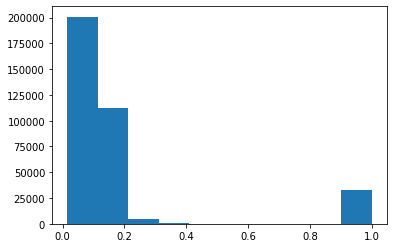

In [69]:
plt.hist(dd['ff_nom'])

In [55]:
a = bigboy.loc['data_obs']

In [56]:
a_cutted = a.query('(pt_1 > 21) & (pt_2 > 20) & (os > 0.5) & (puppimt_1 < 50) & (m_vis > 40) & (abs(eta_1) < 2.1) & (predicted_class == 1) & (IP_signif_RefitV_with_BS_1 > 1.5) & (byMediumDeepTau2017v2p1VSjet_2 > 0.5)')

In [57]:
a_cutted.shape

(252064, 22)

### **Histograms**

In [24]:
%%time
bigboy.loc[idx[:, ['ZTT']], idx['acotautau_helix_00', 'predicted_prob']]

CPU times: user 65.2 ms, sys: 22.1 ms, total: 87.3 ms
Wall time: 65.9 ms


acotautau_helix_00  predicted_prob
input_tuple process event_id                                    
DY          ZTT     3                   0.292456        0.515085
                    5                   4.915074        0.469844
                    7                   2.021982        0.581782
                    8                   3.969867        0.722098
                    10                  3.897804        0.601390
...                                          ...             ...
                    606607              4.357669        0.729100
                    606608              4.492638        0.461158
                    606609              4.834198        0.557689
                    606610              0.604922        0.730460
                    606611              5.283485        0.679310

[396514 rows x 2 columns]

In [25]:
hist_data = bigboy.xs('ZTT', level=1)[['predicted_prob', 'acotautau_helix_00']]

In [26]:
hist_data.acotautau_helix_00.max()

6.283182

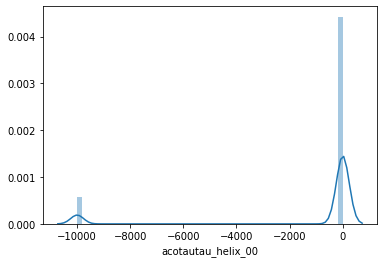

In [28]:
sns.distplot(hist_data.acotautau_helix_00.dropna())

In [32]:
x,y = hist_data.predicted_prob, hist_data.acotautau_helix_00

In [35]:
H, xedges, yedges = np.histogram2d(x,y, bins=list(observable_to_range_nbins.values()))

In [36]:
H

array([[19762., 15765., 14707., 14623., 15106., 24256.],
       [47642., 36836., 33846., 33665., 35334., 58820.]])

In [37]:
H.ravel()

array([19762., 15765., 14707., 14623., 15106., 24256., 47642., 36836.,
       33846., 33665., 35334., 58820.])

In [39]:
type(H.ravel())

numpy.ndarray

In [38]:
np.histogram(H.ravel())

(array([4, 1, 1, 0, 3, 1, 0, 1, 0, 1]),
 array([14623. , 19042.7, 23462.4, 27882.1, 32301.8, 36721.5, 41141.2,
        45560.9, 49980.6, 54400.3, 58820. ]))

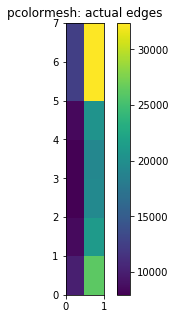

In [131]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(132, title='pcolormesh: actual edges',
        aspect='equal')
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X, Y, H.T)
fig.colorbar(im, ax=ax)